In [30]:
#IMPORTING LIBRARIES

In [32]:
!pip install geopy
!pip install folium
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.neighbors import BallTree
from sklearn.metrics.pairwise import haversine_distances

In [33]:
# Loading the dataset
file_path = 'Stage 1.xlsx'
data = pd.read_excel(file_path)

# Remove rows with NaN values in latitude and longitude
data_cleaned = data.dropna(subset=['Latitude', 'Longitude'])

In [34]:
#checking if there are no null values anymore
print(data_cleaned[['Latitude', 'Longitude']].isnull().sum())

Latitude     0
Longitude    0
dtype: int64


In [35]:
data_cleaned['latitude_radians'] = np.radians(data_cleaned['Latitude'])
data_cleaned['longitude_radians'] = np.radians(data_cleaned['Longitude'])

In [36]:
coords = data_cleaned[['latitude_radians', 'longitude_radians']].values
if coords.size == 0:
    raise ValueError("Coordinates array is empty. Check your data and merging process.")

dist_matrix = haversine_distances(coords) * 6371  # Convert to kilometers

# Define a radius (1 km)
radius = 1

# Identify neighbors within the radius
neighbors = {i: np.where(dist_matrix[i] <= radius)[0] for i in range(len(data_cleaned))}

In [37]:
def calculate_outlier_scores(neighbors, data_cleaned, id_column):
    outlier_scores = []
    for i, neighbor_indices in neighbors.items():
        if len(neighbor_indices) > 1:
            for party in ['APC', 'LP', 'PDP', 'NNPP']:
                votes = data_cleaned.iloc[neighbor_indices][party].values
                z_scores = zscore(votes)
                outlier_scores.append({
                    id_column: data_cleaned.iloc[i][id_column],
                    'party': party,
                    'outlier_score': z_scores[np.where(neighbor_indices == i)[0][0]]
                })
    return pd.DataFrame(outlier_scores)

# Determine the appropriate identifier column
id_column = 'unit_id' if 'unit_id' in data_cleaned.columns else data_cleaned.columns[4]

# Calculate outlier scores
outlier_scores = calculate_outlier_scores(neighbors, data_cleaned, id_column)
print(outlier_scores.head())

               PU-Name party  outlier_score
0  ST. CHARLE'S SCHOOL   APC      -0.543386
1  ST. CHARLE'S SCHOOL    LP      -1.488709
2  ST. CHARLE'S SCHOOL   PDP      -0.325378
3  ST. CHARLE'S SCHOOL  NNPP      -0.509736
4       AMANKWU SQUARE   APC       0.802052


In [38]:
from geopy.distance import geodesic

In [39]:
# Define a function to calculate the outlier score
def calculate_outlier_score(votes, neighbor_votes):
    return abs(votes - np.mean(neighbor_votes))

# Sample DataFrame
data = {
    'PU-Name': ['PU1', 'PU2', 'PU3', 'PU4'],
    'latitude': [6.5244, 6.5245, 6.5246, 6.5247],
    'longitude': [3.3792, 3.3793, 3.3794, 3.3795],
    'APC': [100, 150, 120, 130],
    'LP': [200, 180, 210, 220],
    'PDP': [300, 280, 290, 310],
    'NNPP': [50, 60, 55, 65]
}
data_cleans = pd.DataFrame(data)

# Define a radius (in km)
radius = 1

# Initialize outlier score columns
data_cleans['APC_outlier_score'] = 0.0
data_cleans['LP_outlier_score'] = 0.0
data_cleans['PDP_outlier_score'] = 0.0
data_cleans['NNPP_outlier_score'] = 0.0

# Calculate outlier scores for each polling unit
for i, row in data_cleans.iterrows():
    # Get the coordinates of the current polling unit
    current_coords = (row['latitude'], row['longitude'])

    # Find neighboring polling units
    neighbors = []
    for j, neighbor_row in data_cleans.iterrows():
        if i != j:
            neighbor_coords = (neighbor_row['latitude'], neighbor_row['longitude'])
            distance = geodesic(current_coords, neighbor_coords).kilometers
            if distance <= radius:
                neighbors.append(neighbor_row)

    if neighbors:
        # Calculate outlier scores for each party
        neighbors_df = pd.DataFrame(neighbors)
        data_cleans.at[i, 'APC_outlier_score'] = calculate_outlier_score(row['APC'], neighbors_df['APC'])
        data_cleans.at[i, 'LP_outlier_score'] = calculate_outlier_score(row['LP'], neighbors_df['LP'])
        data_cleans.at[i, 'PDP_outlier_score'] = calculate_outlier_score(row['PDP'], neighbors_df['PDP'])
        data_cleans.at[i, 'NNPP_outlier_score'] = calculate_outlier_score(row['NNPP'], neighbors_df['NNPP'])

print(data_cleans)

  PU-Name  latitude  longitude  APC   LP  PDP  NNPP  APC_outlier_score  \
0     PU1    6.5244     3.3792  100  200  300    50          33.333333   
1     PU2    6.5245     3.3793  150  180  280    60          33.333333   
2     PU3    6.5246     3.3794  120  210  290    55           6.666667   
3     PU4    6.5247     3.3795  130  220  310    65           6.666667   

   LP_outlier_score  PDP_outlier_score  NNPP_outlier_score  
0          3.333333           6.666667           10.000000  
1         30.000000          20.000000            3.333333  
2         10.000000           6.666667            3.333333  
3         23.333333          20.000000           10.000000  


In [ ]:
##Saving the cleaned dataset into a csv file

In [40]:
cleaned_dataset = 'seffy_anambra_election_data_with_outlier_scores.csv'
data_cleans.to_csv(cleaned_dataset, index=False)

print(f"Cleaned dataset saved to {cleaned_dataset}")

Cleaned dataset saved to seffy_anambra_election_data_with_outlier_scores.csv


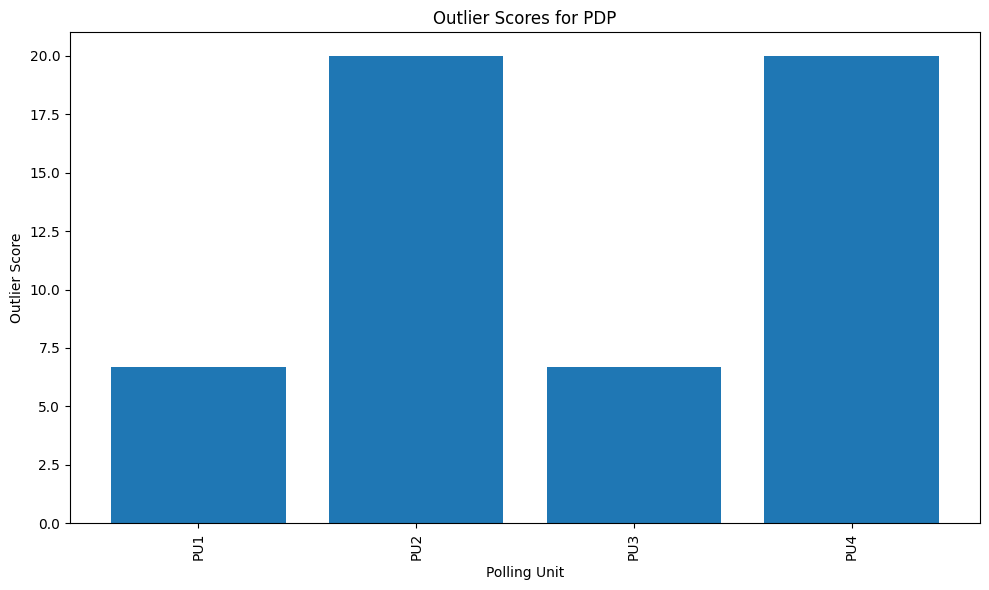

In [41]:
#Visualization starts

# Plotting the bar chart for PDP outlier scores
plt.figure(figsize=(10, 6))
plt.bar(data_cleans['PU-Name'], data_cleans['PDP_outlier_score'])
plt.xticks(rotation=90)
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores for PDP')
plt.tight_layout()
plt.show()

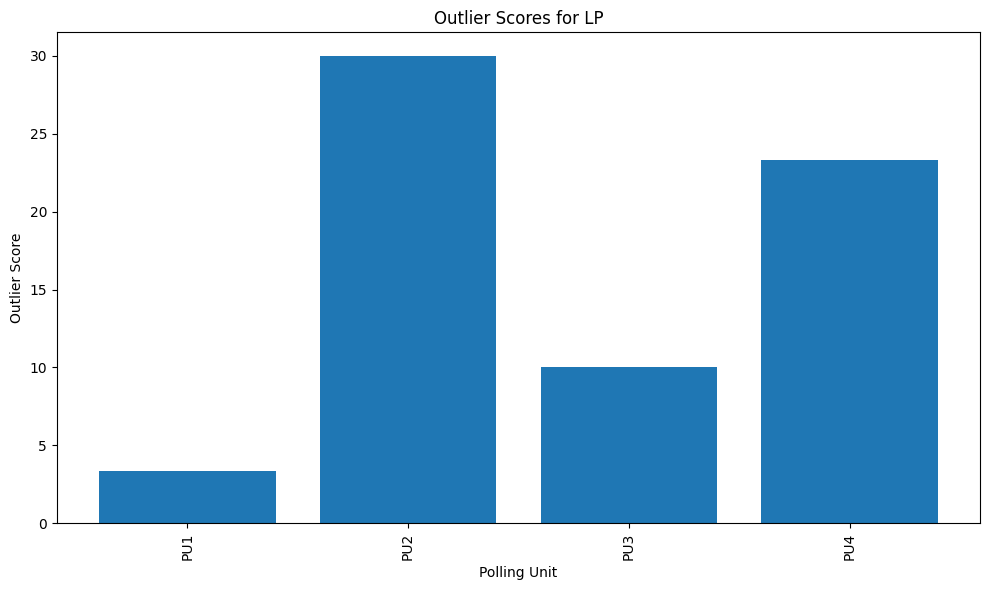

In [42]:
# Plotting the bar chart for PDP outlier scores
plt.figure(figsize=(10, 6))
plt.bar(data_cleans['PU-Name'], data_cleans['LP_outlier_score'])
plt.xticks(rotation=90)
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores for LP')
plt.tight_layout()
plt.show()

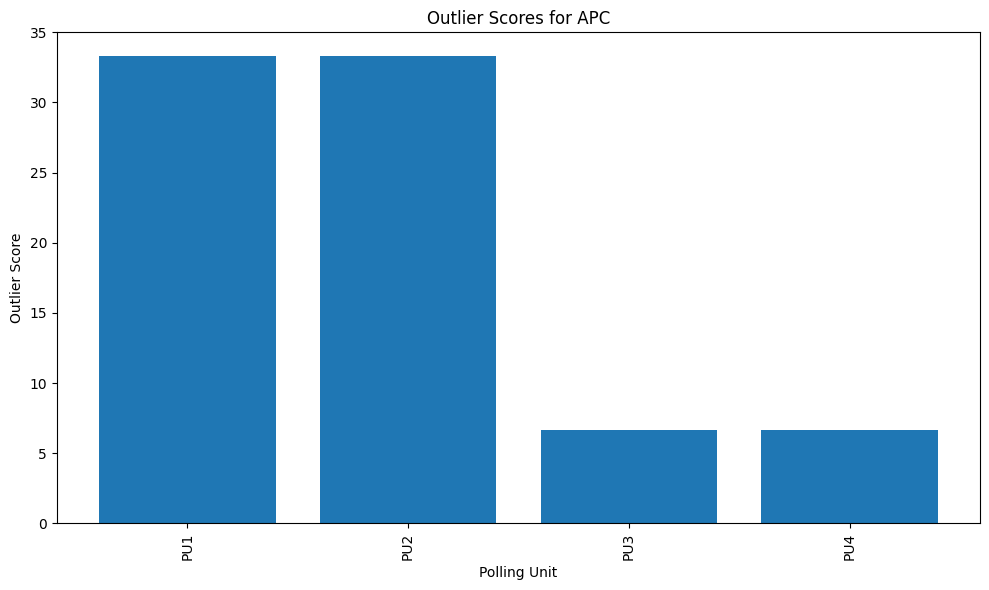

In [43]:
# Plotting the bar chart for PDP outlier scores
plt.figure(figsize=(10, 6))
plt.bar(data_cleans['PU-Name'], data_cleans['APC_outlier_score'])
plt.xticks(rotation=90)
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores for APC')
plt.tight_layout()
plt.show()

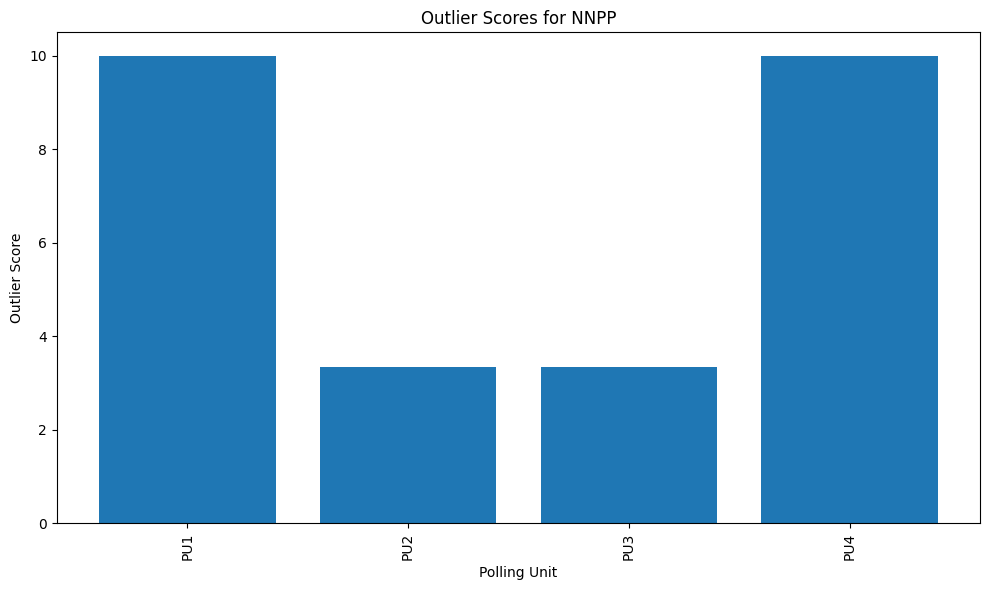

In [44]:
# Plotting the bar chart for PDP outlier scores
plt.figure(figsize=(10, 6))
plt.bar(data_cleans['PU-Name'], data_cleans['NNPP_outlier_score'])
plt.xticks(rotation=90)
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores for NNPP')
plt.tight_layout()
plt.show()

In [47]:
# Define the center of Anambra State
anambra_centre = [6.2100, 7.0700]

# Create a Folium map centered around Anambra State
m = folium.Map(location=anambra_centre, zoom_start=10)  # Adjust zoom_start as needed

# Adding markers for each polling unit
for index, row in data_cleans.iterrows():
    # Ensure coordinates are within Anambra State
    if row['latitude'] < 5.5 or row['latitude'] > 7.8 or row['longitude'] < 6.5 or row['longitude'] > 7.9:
        continue  # Skip markers outside Anambra State
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Polling Unit: {row['PU-Name']}\n"
              f"APC Outlier Score: {row['APC_outlier_score']}\n"
              f"LP Outlier Score: {row['LP_outlier_score']}\n"
              f"PDP Outlier Score: {row['PDP_outlier_score']}\n"
              f"NNPP Outlier Score: {row['NNPP_outlier_score']}"
    ).add_to(m)

# Save the map as an HTML file
m.save('polling_units_map.html')

# Display the map
m

In [51]:
#Sorting the dataset by outlier scores
sorted_outliers = outlier_scores.sort_values(by='outlier_score', ascending=False)
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)
print(sorted_outliers.head())

                              PU-Name party  outlier_score
1178                      AMA-OKPOGBA   PDP      12.839118
9662              MODEBE MEMO P/S III   PDP      12.635357
11232                   UMUNEBO P/S I   APC      12.000627
7327                  UMUEZEAGU P/S I  NNPP      11.561981
13667  URBAN BOYS SECONDARY SCHOOL  I  NNPP      11.335126


In [52]:
#Identify top 3 outliers for each party
top_outliers = sorted_outliers.groupby('party').head(3)
print(top_outliers)

                              PU-Name party  outlier_score
1178                      AMA-OKPOGBA   PDP      12.839118
9662              MODEBE MEMO P/S III   PDP      12.635357
11232                   UMUNEBO P/S I   APC      12.000627
7327                  UMUEZEAGU P/S I  NNPP      11.561981
13667  URBAN BOYS SECONDARY SCHOOL  I  NNPP      11.335126
2903         COMMUNITY PRY. SCHOOL II  NNPP      11.192704
10078             OKAA AGBILIGBA HALL   PDP      11.176221
3872            NKWO AMENYI SQUARE II   APC      10.614566
10124                   EZENDU SQUARE   APC      10.320459
1177                      AMA-OKPOGBA    LP       6.340112
1169                     AMA-ENUGU II    LP       6.104308
4097                   G.T.C COMPOUND    LP       4.916632


In [53]:
# Explain why they are outliers
for index, row in top_outliers.iterrows():
    identifier = row[id_column]
    party = row['party']
    score = row['outlier_score']
    print(f"Unit {identifier} is an outlier for {party} with an outlier score of {score}.")

Unit AMA-OKPOGBA is an outlier for PDP with an outlier score of 12.839117745291805.
Unit MODEBE MEMO P/S III is an outlier for PDP with an outlier score of 12.635356713952119.
Unit UMUNEBO P/S I is an outlier for APC with an outlier score of 12.000627263241743.
Unit UMUEZEAGU P/S I is an outlier for NNPP with an outlier score of 11.56198143144458.
Unit URBAN BOYS SECONDARY SCHOOL  I is an outlier for NNPP with an outlier score of 11.335125970441581.
Unit COMMUNITY PRY. SCHOOL II is an outlier for NNPP with an outlier score of 11.192703643249285.
Unit OKAA AGBILIGBA HALL is an outlier for PDP with an outlier score of 11.176221160080914.
Unit NKWO AMENYI SQUARE II is an outlier for APC with an outlier score of 10.614565989138514.
Unit EZENDU SQUARE is an outlier for APC with an outlier score of 10.3204594420091.
Unit AMA-OKPOGBA is an outlier for LP with an outlier score of 6.340112420528137.
Unit AMA-ENUGU II is an outlier for LP with an outlier score of 6.104308343088281.
Unit G.T.C CO

In [54]:
# Save sorted outlier scores to a CSV file
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)

In [55]:
# Identify top 3 outliers for each party
top_outliers = sorted_outliers.groupby('party').head(3)

# Save top outliers to a CSV file
top_outliers.to_csv('top_outliers.csv', index=False)

In [57]:
# Save the full dataset with calculated columns
data_cleans.to_csv('full_dataset_with_calculations.csv', index=False)

In [58]:
# Print statements to confirm saving
print("Sorted outlier scores saved to 'sorted_outlier_scores.csv'")
print("Top 3 outliers for each party saved to 'top_outliers.csv'")
print("Full dataset with calculations saved to 'full_dataset_with_calculations.csv'")

Sorted outlier scores saved to 'sorted_outlier_scores.csv'
Top 3 outliers for each party saved to 'top_outliers.csv'
Full dataset with calculations saved to 'full_dataset_with_calculations.csv'
